[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# How To Perform Vision Tasks Using Florence 2

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/<BLOG_NAME>)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
[![Scientific Paper](https://img.shields.io/badge/Official-Paper-blue.svg)](<PAPER LINK>)


In [ ]:
! uv pip install transformers requests torch pillow matplotlib opencv-python

In [ ]:
import requests
import copy
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
%matplotlib inline

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

from transformers import AutoProcessor, AutoModelForCausalLM
# AutoProcessor, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

In [ ]:
url = "https://i.pinimg.com/736x/11/20/e8/1120e816a431d7b40036cb59a592a0fb.jpg"
sample_1 = Image.open(requests.get(url, stream=True).raw)
sample_1

In [ ]:
# funtion for image captioning
def florence2(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    image = image.convert("RGB")
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

# **IMAGE CAPTIONING**

In [ ]:
task_prompt = '<CAPTION>'
florence2(task_prompt, sample_1)

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
florence2(task_prompt, sample_1)

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
florence2(task_prompt, sample_1)

# **OBJECT DETECTION AND RECOGNITION**

In [55]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [56]:
task_prompt = '<OD>'
results = florence2(task_prompt, sample_1)
print(results)

{'<OD>': {'bboxes': [[26.82750129699707, 379.5050048828125, 461.2124938964844, 486.81500244140625], [59.90250015258789, 303.06500244140625, 433.2825012207031, 360.885009765625], [54.75749969482422, 361.375, 436.95751953125, 409.885009765625], [65.04750061035156, 343.7350158691406, 436.2225036621094, 383.9150085449219], [473.70751953125, 139.89500427246094, 598.6575317382812, 422.625], [129.72750854492188, 194.28500366210938, 325.9725036621094, 331.9750061035156], [584.6925048828125, 185.46499633789062, 669.217529296875, 438.3050231933594]], 'labels': ['book', 'book', 'book', 'book', 'bottle', 'camera', 'vase']}}


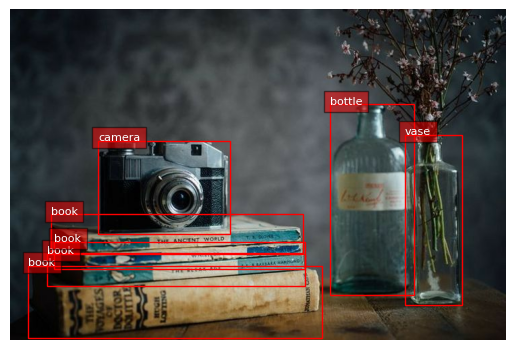

In [57]:
plot_bbox(sample_1, results['<OD>'])

In [58]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = florence2(task_prompt, sample_1)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[467.0924987792969, 0.24500000476837158, 734.6325073242188, 438.3050231933594], [26.82750129699707, 379.5050048828125, 461.2124938964844, 486.81500244140625], [473.70751953125, 139.89500427246094, 598.6575317382812, 422.625], [129.72750854492188, 194.28500366210938, 325.9725036621094, 331.9750061035156], [584.6925048828125, 185.46499633789062, 669.217529296875, 438.3050231933594], [59.90250015258789, 303.06500244140625, 433.2825012207031, 360.885009765625], [54.75749969482422, 361.375, 436.95751953125, 409.885009765625], [65.78250122070312, 343.7350158691406, 435.4875183105469, 383.9150085449219]], 'labels': ['vintage books on wooden table with cherry blossom branches in glass bottles', 'vintage medical books', 'bottle', 'camera', 'vase', 'book', 'book', 'book']}}


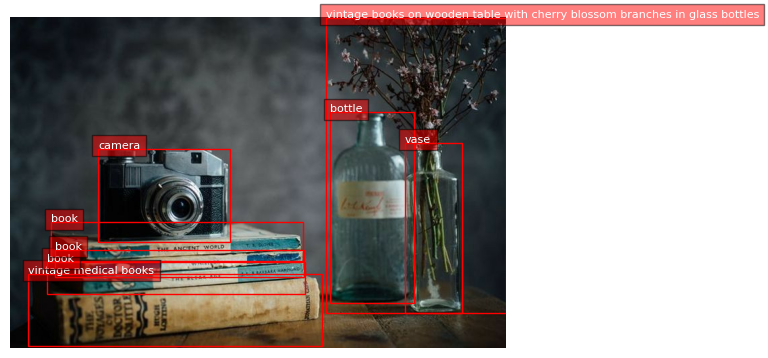

In [59]:
plot_bbox(sample_1, results['<DENSE_REGION_CAPTION>'])

In [60]:
task_prompt = '<REGION_PROPOSAL>'
results = florence2(task_prompt, sample_1)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[467.0924987792969, 0.24500000476837158, 734.6325073242188, 438.3050231933594], [0.3675000071525574, 392.2449951171875, 734.6325073242188, 489.2650146484375], [26.092500686645508, 303.55499267578125, 463.4175109863281, 487.3050231933594], [468.5625, 0.24500000476837158, 734.6325073242188, 187.91500854492188], [27.5625, 379.9949951171875, 461.2124938964844, 486.81500244140625], [473.70751953125, 139.89500427246094, 598.6575317382812, 422.625], [129.72750854492188, 194.28500366210938, 325.9725036621094, 331.9750061035156], [59.90250015258789, 303.06500244140625, 433.2825012207031, 360.885009765625], [584.6925048828125, 185.46499633789062, 669.217529296875, 438.3050231933594], [54.75749969482422, 361.375, 436.95751953125, 409.885009765625], [65.04750061035156, 343.7350158691406, 436.2225036621094, 383.9150085449219]], 'labels': ['', '', '', '', '', '', '', '', '', '', '']}}


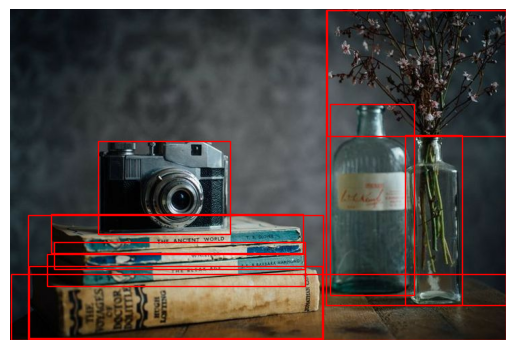

In [61]:
plot_bbox(sample_1, results['<REGION_PROPOSAL>'])

# **SEGEMENTATION**

In [62]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

In [63]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, sample_1, text_input="camera")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[145.8975067138672, 197.22500610351562, 182.6475067138672, 197.22500610351562, 184.85250854492188, 198.2050018310547, 185.58750915527344, 200.16500854492188, 185.58750915527344, 206.0449981689453, 184.85250854492188, 207.02500915527344, 184.1175079345703, 209.9650115966797, 184.1175079345703, 213.885009765625, 185.58750915527344, 215.84500122070312, 201.75750732421875, 215.84500122070312, 203.96250915527344, 214.86500549316406, 206.16751098632812, 212.90499877929688, 206.16751098632812, 205.06500244140625, 204.697509765625, 204.0850067138672, 203.96250915527344, 201.14500427246094, 203.96250915527344, 198.2050018310547, 206.16751098632812, 197.22500610351562, 207.6374969482422, 195.7550048828125, 215.72250366210938, 194.77500915527344, 228.95249938964844, 194.77500915527344, 259.0874938964844, 195.7550048828125, 260.5574951171875, 198.2050018310547, 262.76251220703125, 198.2050018310547, 265.7025146484375, 195.7550048828125, 287.75

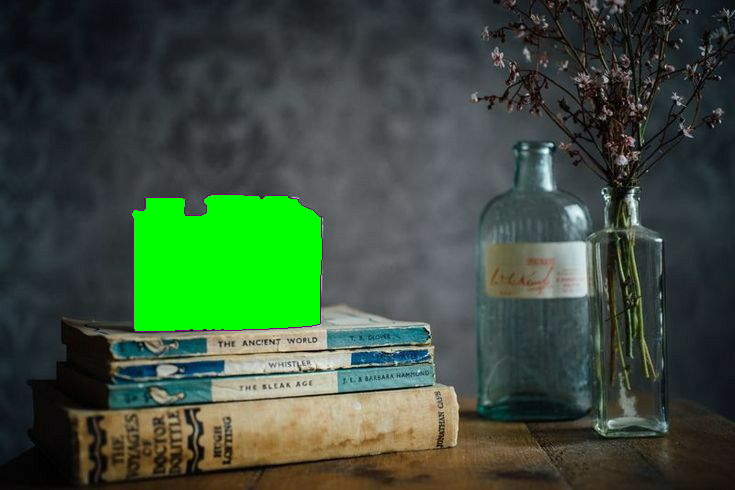

In [64]:
output_image = copy.deepcopy(sample_1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[62.84250259399414, 316.7850036621094, 65.78250122070312, 316.7850036621094, 70.92749786376953, 317.7650146484375, 71.6624984741211, 318.7449951171875, 77.5425033569336, 319.7250061035156, 87.83250427246094, 320.70501708984375, 98.85749816894531, 321.68499755859375, 112.82250213623047, 321.68499755859375, 126.78750610351562, 322.6650085449219, 129.72750854492188, 323.64501953125, 131.9324951171875, 324.625, 132.66749572753906, 327.56500244140625, 134.87249755859375, 329.5249938964844, 137.07749938964844, 330.5050048828125, 140.75250244140625, 331.4850158691406, 148.83750915527344, 331.4850158691406, 149.572509765625, 330.5050048828125, 168.68251037597656, 329.5249938964844, 198.8175048828125, 329.5249938964844, 199.55250549316406, 328.5450134277344, 222.33750915527344, 327.56500244140625, 255.41250610351562, 327.56500244140625, 256.1474914550781, 326.5849914550781, 269.37750244140625, 325.6050109863281, 286.2825012207031, 325.60501

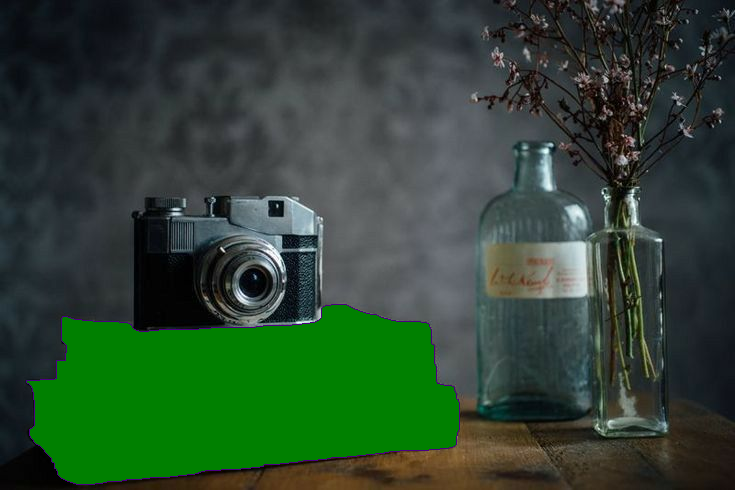

In [65]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, sample_1, text_input="book")
print(results)
output_image = copy.deepcopy(sample_1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[514.1325073242188, 145.28500366210938, 517.072509765625, 142.34500122070312, 519.2775268554688, 141.36500549316406, 551.6174926757812, 141.36500549316406, 553.0875244140625, 142.34500122070312, 554.5574951171875, 144.3050079345703, 554.5574951171875, 148.22500610351562, 553.0875244140625, 151.16500854492188, 552.3525390625, 152.14500427246094, 551.6174926757812, 155.0850067138672, 551.6174926757812, 168.31500244140625, 552.3525390625, 176.15499877929688, 553.0875244140625, 182.03500366210938, 554.5574951171875, 185.9550018310547, 555.29248046875, 188.40499877929688, 557.4974975585938, 190.36500549316406, 559.7025146484375, 191.34500122070312, 562.6425170898438, 192.3249969482422, 565.58251953125, 192.3249969482422, 568.5225219726562, 194.28500366210938, 569.9924926757812, 194.28500366210938, 572.197509765625, 195.26499938964844, 574.4025268554688, 197.22500610351562, 577.342529296875, 198.2050018310547, 580.2825317382812, 200.1650

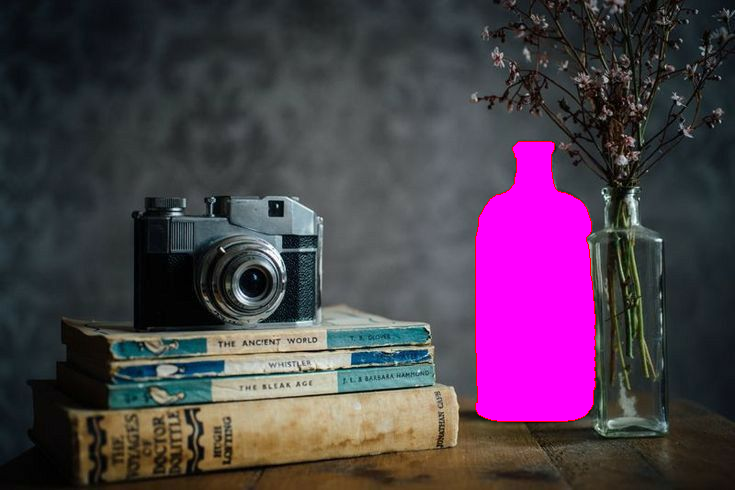

In [66]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, sample_1, text_input="bottle")
print(results)
output_image = copy.deepcopy(sample_1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[601.5975341796875, 189.385009765625, 603.802490234375, 187.4250030517578, 606.0075073242188, 186.44500732421875, 608.947509765625, 186.44500732421875, 609.6824951171875, 187.4250030517578, 612.6224975585938, 188.40499877929688, 617.7675170898438, 188.40499877929688, 620.70751953125, 188.40499877929688, 625.8525390625, 188.40499877929688, 626.5875244140625, 187.4250030517578, 634.6724853515625, 186.44500732421875, 637.6124877929688, 186.44500732421875, 639.8175048828125, 188.40499877929688, 639.8175048828125, 191.34500122070312, 638.3475341796875, 192.3249969482422, 637.6124877929688, 201.14500427246094, 637.6124877929688, 217.31500244140625, 638.3475341796875, 222.2150115966797, 639.8175048828125, 224.1750030517578, 642.0225219726562, 226.135009765625, 644.2275390625, 228.09500122070312, 646.4324951171875, 229.0749969482422, 648.6375122070312, 229.0749969482422, 651.5775146484375, 231.03500366210938, 653.7825317382812, 231.0350036

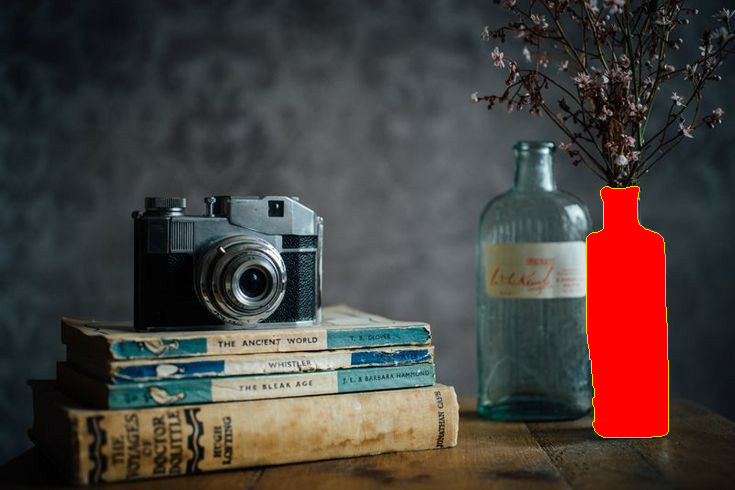

In [67]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, sample_1, text_input="vase")
print(results)
output_image = copy.deepcopy(sample_1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[482.5274963378906, 32.584999084472656, 483.26251220703125, 30.625, 486.2025146484375, 27.685001373291016, 488.4075012207031, 27.685001373291016, 491.3475036621094, 29.645000457763672, 494.2875061035156, 29.645000457763672, 497.2275085449219, 28.665000915527344, 499.4324951171875, 27.685001373291016, 501.63751220703125, 25.725000381469727, 504.5775146484375, 24.7450008392334, 506.0475158691406, 22.78499984741211, 508.25250244140625, 21.80500030517578, 510.45751953125, 21.80500030517578, 512.6625366210938, 19.845001220703125, 513.3975219726562, 17.885000228881836, 513.3975219726562, 15.925000190734863, 512.6625366210938, 13.96500015258789, 506.0475158691406, 7.595000267028809, 505.3125, 7.595000267028809, 502.37249755859375, 5.635000228881836, 499.4324951171875, 2.695000171661377, 499.4324951171875, 0.24500000476837158, 682.447509765625, 0.24500000476837158, 683.1824951171875, 2.695000171661377, 683.1824951171875, 4.65500020980835, 

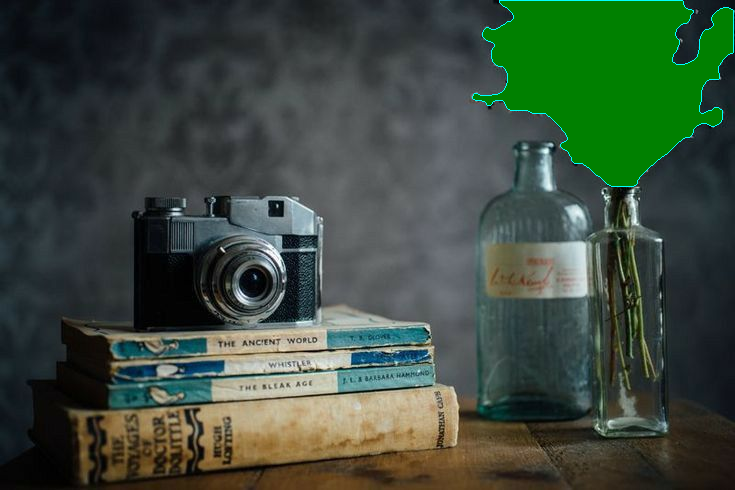

In [68]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = florence2(task_prompt, sample_1, text_input="cherry blossom branches")
print(results)
output_image = copy.deepcopy(sample_1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[128.9925079345703, 191.8350067138672, 326.70751953125, 332.95501708984375], [26.82750129699707, 302.57501220703125, 461.947509765625, 486.32501220703125], [26.82750129699707, 302.57501220703125, 461.2124938964844, 486.32501220703125], [2.572499990463257, 389.7950134277344, 732.427490234375, 488.2850036621094], [467.8275146484375, 2.2049999237060547, 732.427490234375, 440.2650146484375], [584.6925048828125, 183.5050048828125, 671.4224853515625, 440.2650146484375]], 'labels': ['an old camera', 'a stack', 'books', 'a table', 'a flower vase', 'a flower vase']}}


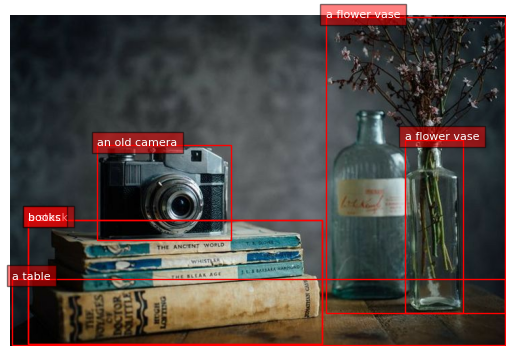

In [69]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = florence2(task_prompt,sample_1, text_input="The image shows an old camera sitting atop a stack of books on a table, with a flower vase beside it. The background is slightly blurred, giving the image a dreamy feel.")
print(results)
plot_bbox(sample_1, results['<CAPTION_TO_PHRASE_GROUNDING>'])

# OCR

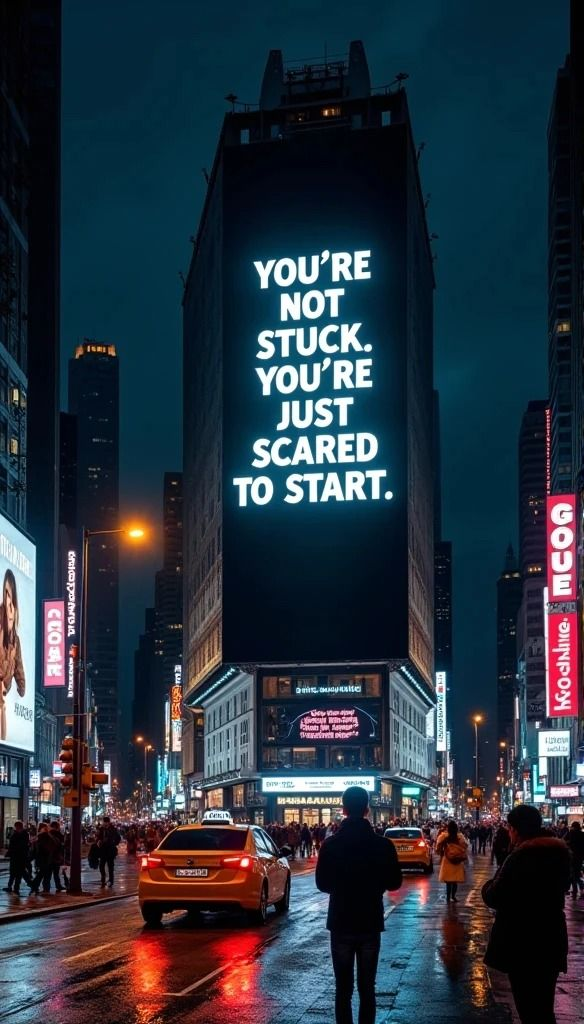

In [70]:
url = "https://i.pinimg.com/736x/e5/2a/10/e52a101363cc4c7f2d51e4cfa7dc966e.jpg"
sample_2 = Image.open(requests.get(url, stream=True).raw)
sample_2

In [71]:
task_prompt = '<OCR>'
florence2(task_prompt, sample_2)

{'<OCR>': "YOU'RE\nNOT\nSTUCK.\nYOU're\nJUST\nSCARED\nTO START.\nGOO\nCIO-E\nKochaline.\nLIZCEM\n"}

In [72]:
task_prompt = '<OCR_WITH_REGION>'
results = florence2(task_prompt, sample_2)
print(results)

{'<OCR_WITH_REGION>': {'quad_boxes': [[250.24400329589844, 258.55999755859375, 371.1319885253906, 247.29600524902344, 374.052001953125, 279.0400085449219, 253.16400146484375, 290.30401611328125], [277.1080017089844, 292.3520202636719, 344.26800537109375, 286.2080078125, 347.18798828125, 315.9040222167969, 278.8599853515625, 322.0480041503906], [251.41200256347656, 329.21600341796875, 369.9639892578125, 320.0, 372.8840026855469, 350.72003173828125, 254.33200073242188, 360.96002197265625], [251.41200256347656, 365.0560302734375, 372.8840026855469, 355.84002685546875, 375.2200012207031, 387.5840148925781, 254.33200073242188, 397.8240051269531], [273.0199890136719, 399.87200927734375, 353.0279846191406, 394.75201416015625, 354.19598388671875, 426.49603271484375, 274.18798828125, 431.61602783203125], [247.32398986816406, 436.73602294921875, 376.97198486328125, 430.5920104980469, 378.7239990234375, 462.3360290527344, 248.4919891357422, 469.5040283203125], [230.38800048828125, 473.60003662109

In [73]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

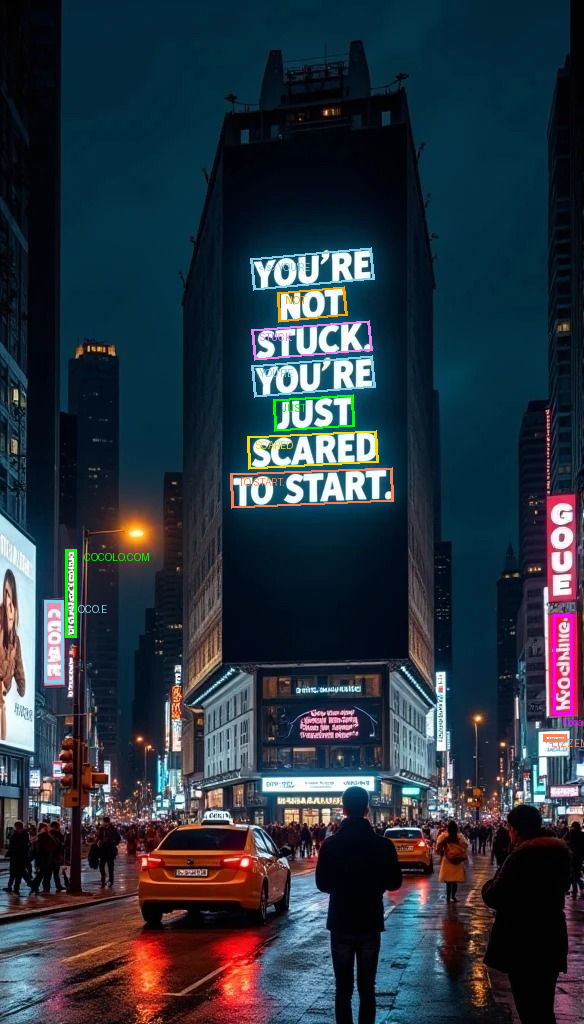

In [74]:
draw_ocr_bboxes(sample_2, results['<OCR_WITH_REGION>'])